# Model to predict income segregation level of visitors
Neural networks.

In [1]:
%load_ext autoreload
%autoreload 2
%cd D:\mobi-social-segregation-se

D:\mobi-social-segregation-se


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.constraints import MaxNorm

# Import necessary modules
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import eli5
from eli5.sklearn import PermutationImportance

# Keras specific
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout

C:\Users\yuanlia\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


## 1. Load data and process features

In [3]:
df = pd.read_parquet("results/data4model_agg.parquet")
df.head()

,number_of_locations,number_of_visits,average_displacement,radius_of_gyration,median_distance_from_home,Not Sweden,Lowest income group,car_ownership,cum_jobs,cum_stops,num_jobs,num_stops,gsi,length_density,evenness_income
0,46.0,330.778708,4.452007,14.510179,2.073022,0.192247,0.139807,0.696203,12135.951891,9.000000,13.033933,1.273545,0.003682,3.345828,0.130333
1,45.0,230.000000,10.322766,34.107674,0.000000,0.218274,0.089744,0.502488,24918.872026,15.000000,203.445651,10.627759,0.105551,33.597370,0.245635
2,36.0,215.000000,6.445591,50.263578,0.551933,0.154839,0.080000,0.511180,23410.711393,20.443124,2143.848431,14.621303,0.155050,51.239254,0.190971
3,20.0,112.000000,1.851936,6.565244,0.000000,0.141501,0.081633,0.482875,24174.494807,23.000000,285.487269,23.790607,0.115653,49.684910,0.195091
4,19.0,159.000000,10.574411,28.792174,0.000000,0.312000,0.210526,0.423274,22752.178252,20.000000,403.702805,6.494576,0.042250,21.365158,0.072532


In [32]:
predictors = ['number_of_locations', 'number_of_visits', 'average_displacement', 'radius_of_gyration', 'median_distance_from_home',
            'Not Sweden', 'Lowest income group', 'car_ownership',
            'cum_jobs', 'cum_stops',
            'num_jobs', 'num_stops', 'gsi', 'length_density']
target_column = 'evenness_income'
X = df[predictors].values
y = df[target_column].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=40)
print(X_train.shape); print(X_test.shape)

(5385, 14)
(599, 14)


### 1.1 Preprocess features

In [33]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

## 2. Keras model

In [34]:
# Define model
model = Sequential()
model.add(Dense(500, input_dim=14, activation= "relu", kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(100, activation= "relu", kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(50, activation= "relu", kernel_constraint=MaxNorm(3)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

### 2.1 Train the model

In [35]:
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.fit(X_train, y_train, epochs=20)

Epoch 1/20
169/169 [==============================] - 2s 6ms/step - loss: 0.0131 - mean_squared_error: 0.0131
Epoch 2/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 3/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 4/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 5/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0054 - mean_squared_error: 0.0054
Epoch 6/20
169/169 [==============================] - 1s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 7/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 8/20
169/169 [==============================] - 1s 4ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 9/20
169/169 [==============================] - 1s 5ms/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 10/2

### 2.2 Performance

In [36]:
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred)))

169/169 [==============================] - 0s 2ms/step
0.05791514867028582
19/19 [==============================] - 0s 868us/step
0.06629869564346445


#### Visualise the results

In [37]:
df_preds_train = pd.DataFrame()
df_preds_train['evenness_income'] = y_train
df_preds_train['prediction'] = pred_train
df_preds_test = pd.DataFrame()
df_preds_test['evenness_income'] = y_test
df_preds_test['prediction'] = pred
df_preds_train.loc[:, 'label'] = 'train'
df_preds_test.loc[:, 'label'] = 'test'
df_preds = pd.concat([df_preds_train, df_preds_test])

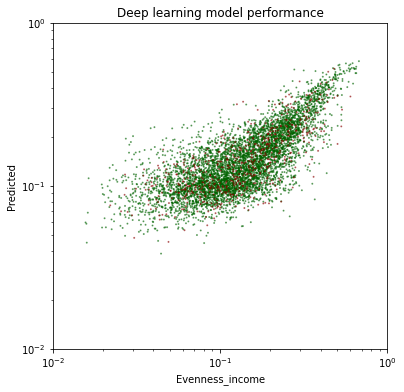

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.scatter(x=df_preds['evenness_income'], y=df_preds['prediction'], s=1,
            c=df_preds['label'].map({'train':'darkgreen','test':'darkred'}), alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**(-2), 1)
plt.ylim(10**(-2), 1)
plt.xlabel("Evenness_income")
plt.ylabel("Predicted")
plt.title('Deep learning model performance')
plt.show()

- As shown in the above figure, the deep learning model performs the best for higher income segregation levels than lower values.
- The performance has small difference between the training set and the test set, indicating a low risk of overfitting.
- As compared with the best baseline model (RMSE=0.071-0.074), the deep learning model performs better (RMSE=0.060-0.066) which significantly improves the prediction of the cases with small segregation values.

## 3. Feature importance

In [44]:
import shap

X_train_summary = shap.kmeans(X_train, 50)
explainer = shap.KernelExplainer(model, X_train_summary)
shap_values = explainer.shap_values(X_train)

  0%|          | 0/5385 [00:00<?, ?it/s]

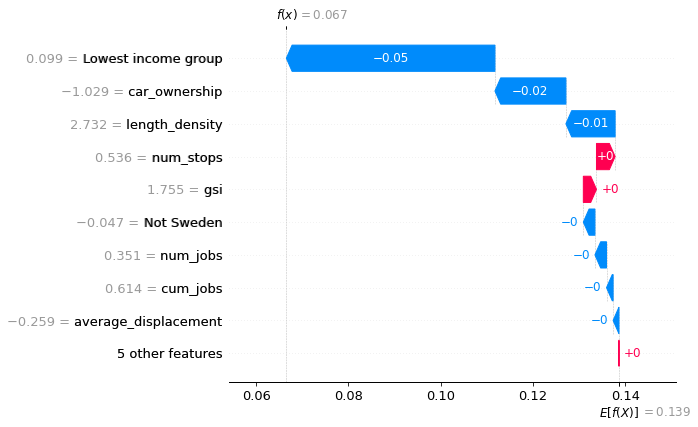

In [54]:
values = shap_values[0]
base_values = [explainer.expected_value[0]]*len(shap_values[0])

tmp = shap.Explanation(values = np.array(values, dtype=np.float32),
                       base_values = np.array(base_values, dtype=np.float32),
                       data=np.array(X_train),
                       feature_names=predictors)

shap.plots.waterfall(tmp[0])

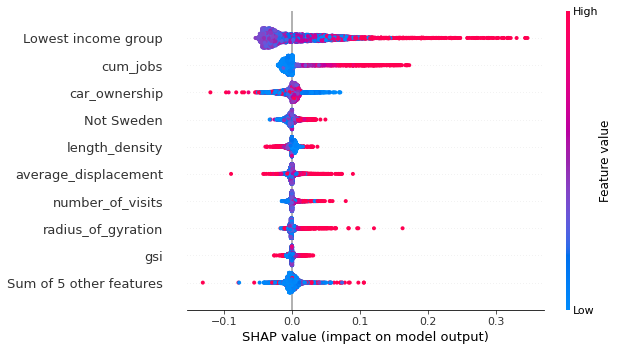

In [55]:
shap.plots.beeswarm(tmp)

- The share of lowest income group among visitors contribute positively to income segregation levels.
- The better the accessibility to jobs of these visitors, the more likely these areas being visited have higher income segregation.
- Lower car ownership of visitors contributes to higher income segregation level.
- A higher share of birth background not in Sweden is associated with slightly higher income segregation level.
- If the visitors have long travel range, these places being visited tend to have higher income segregation level.